# 의료영상 U-Net 용종검출



의료영상의 특징을 살펴보기 위해 오늘 우리가 다룰 위내시경 용종 데이터셋을 전처리하고 시각화하는 과정을 먼저 진행해 보겠습니다.

아래와 같이 주요 라이브러리를 로딩해 줍니다.

In [1]:
import tensorflow
import sklearn
import numpy

print(tensorflow.__version__)
print(sklearn.__version__)
print(numpy.__version__)

2.6.0
1.0
1.21.4


In [2]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


## 데이터 준비

오늘의 프로젝트는 Giana Dataset에서 제공하는 용종 내시경 데이터셋을 이용하여 진행할 것입니다.
오늘 우리가 사용할 영상의 그랜드챌린지 기간이 지났다면 데이터 다운로드가 원활하지 않을 수 있습니다. 그래서 아래 코드를 통해 데이터를 준비해 줍니다.

In [3]:
!mkdir -p ~/aiffel/medical
!ln -s ~/data/* ~/aiffel/medical

ln: failed to create symbolic link '/aiffel/aiffel/medical/ed_ckpt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/train': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/train_labels': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/unet_ckpt': File exists


## Split dataset into train data and test data

위에서 다운로드한 데이터셋을 학습용과 테스트용으로 분리하겠습니다. 데이터셋의 이미지와 라벨은 각각 train, train_labels 디렉토리에 분리되어 있고, 쌍을 이루는 이미지와 라벨의 파일명은 동일합니다. 그리고 사이킷런의 train_test_split을 이용해서 학습(train) 데이터와 테스트(test) 데이터를 분리할 것입니다.

In [4]:
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [5]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [6]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [7]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


## Visualization

데이터 셋에서 이미지 샘플을 5개 정도 살펴봅시다.

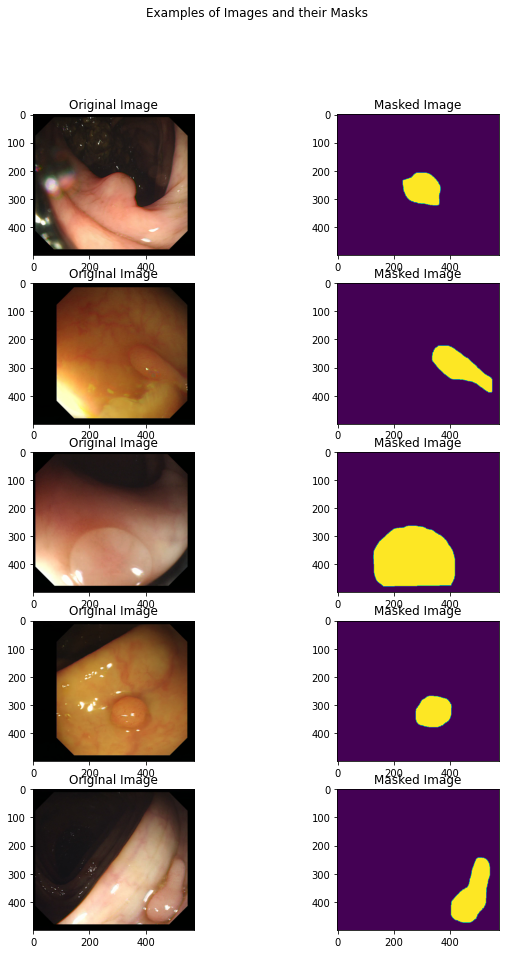

In [8]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

Set up hyper-parameters
공통적으로 적용될 하이퍼파라미터를 미리 셋팅해 두겠습니다.

In [9]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 10

Processing each pathname
실제 이미지 데이터를 로드하는 함수를 구현해 봅시다. 이 함수 안에서는 다음과 같은 작업을 수행합니다.

byte 형태로 데이터를 로드하고, bmp로 디코딩합니다.
디코딩이 완료된 image를 scale과 size를 조절합니다.

In [10]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

Data augmentation - Shifting the image
아래는 로드한 이미지를 기반으로 이미지의 위치를 적절히 이동(shift)시키는 함수입니다. 입력이미지와 라벨의 쌍을 동일하게 shift시켜주어야 합니다.

In [11]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

Data augmentation - Flipping the image randomly
아래는 로드한 이미지를 기반으로 이미지를 flip하는 함수입니다. 50%의 확률로 좌우반전만 구현하였고, 상하반전은 적용하지 않았습니다.

In [12]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

Data augmentation Assembling
위에서 구현한 Augmentation용 함수를 이용해 Data augmentation에 사용하는 _augment() 함수를 구성합니다. 위에서 적용한 것들 이외에도 resize, hue_delta가 적용됩니다.

In [13]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

Set up train and test datasets
이제 tf.data.Dataset을 이용하여 데이터셋 배치구성, 셔플링 등을 구현합니다. 이때 위에서 만들어온 augmentation도 함께 적용됩니다. 단, Train dataset에서만 Data augmentation을 진행하게 설정하는 것에 주의해 주세요.

In [14]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [15]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

Plot some train data
지금까지 구성한 학습 데이터를 확인해 봅시다. 특히 data augmentation 효과가 잘 적용되었을지 눈여겨 보도록 합시다.

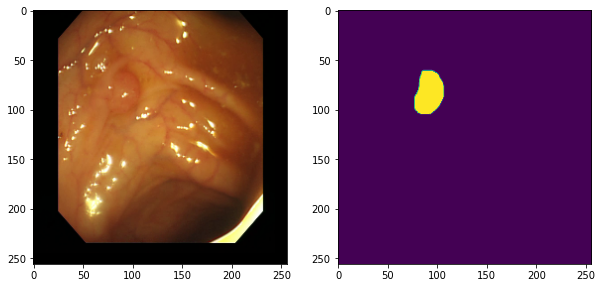

In [16]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

#### Encoder
input data의 shape가 다음과 같이 되도록 네트워크를 구성합니다.

inputs = [batch_size, 256, 256, 3]
conv1 = [batch_size, 128, 128, 64]
conv2 = [batch_size, 64, 64, 128]
conv3 = [batch_size, 32, 32, 256]
outputs = [batch_size, 16, 16, 512]
Convolution - Normalization - Activation 등의 조합을 다양하게 생각해 봅시다.
Encoder의 차원을 줄여가는 방법으로 Pooling을 쓸지 Convolution with stride=2 로 할지 선택해 볼 수 있습니다.
tf.keras.Sequential()을 이용하여 만들어 봅시다.

#### Decoder
Encoder의 mirror 형태로 만들어 봅시다.
input data의 shape이 다음과 같이 되도록 네트워크를 구성합니다.
inputs = encoder의 outputs = [batch_size, 16, 16, 512]
conv_transpose1 = [batch_size, 32, 32, 256]
conv_transpose2 = [batch_size, 64, 64, 128]
conv_transpose3 = [batch_size, 128, 128, 64]
outputs = [batch_size, 256, 256, 1]
tf.keras.Sequential()을 이용하여 만들어 봅시다.

In [17]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [18]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(8, 16, 16, 512)


In [19]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [20]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(8, 256, 256, 1)


Create a encoder-decoder model
지금까지 Encoder와 Decoder를 잘 만들어 왔다면 이 둘을 결합한 모델은 다음과 같이 간단히 구성할 수 있습니다.

In [30]:
model_ed = tf.keras.Sequential()

model_ed.add(encoder)
model_ed.add(decoder)

Model subclassing을 활용한 구현
U-Net은 Encoder-Decoder 구조와는 달리 해당 레이어의 outputs이 바로 다음 레이어의 inputs이 되지 않습니다. 이럴때는 위에 Encoder-Decoder 모델처럼 tf.keras.Sequential()을 쓸 수가 없게 됩니다.

Sequential 구조가 아닌 네트워크를 만들 때 쓸 수 있는 API 가 바로 tf.keras functional API 입니다. 오늘 우리는 U-Net 구현을 위해 Model subclassing 방식을 사용하여, tf.keras.Model 클래스를 상속하여 구현할 것입니다.

In [31]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [32]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [33]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [34]:
model_unet = UNet()

Cross-entropy loss와 Dice loss를 같이 사용해 meanIoU를 더 올리도록 학습할 수 있다.

In [35]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

Dice Loss가 최대화되는 방향으로 구해지도록, 아래와 같이 사용합니다.

In [36]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

새로운 Loss function을 사용하기위해서 기존에 사용하였던 Binary crossentropy loss와 새로 구현한 Dice loss를 더하는 방식으로 구성합니다.

In [37]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [38]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

## ED Model

In [39]:
#print('select the Encoder-Decoder model')
model_ed = ed_model
checkpoint_dir_ed = os.path.join(DATASET_PATH,'train_ckpt/ed_model')

In [41]:
model_ed.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions_ed = model_ed(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions_ed.shape)

(8, 256, 256, 1)


In [42]:
model_ed.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (8, 16, 16, 512)          4693056   
_________________________________________________________________
decoder (Sequential)         (8, 256, 256, 1)          2354913   
Total params: 7,047,969
Trainable params: 7,042,209
Non-trainable params: 5,760
_________________________________________________________________


In [43]:
if not os.path.isdir(checkpoint_dir_ed):
    os.makedirs(checkpoint_dir_ed)

cp_callback_ed = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir_ed,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [44]:
cos_decay_ed = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback_ed = tf.keras.callbacks.LearningRateScheduler(cos_decay_ed, verbose=1)

In [50]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model_ed(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [46]:
history_ed = model_ed.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback_ed, lr_callback_ed]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 12s 208ms/step - loss: 1.1077 - dice_loss: 0.7515 - val_loss: 3.6600 - val_dice_loss: 0.8845
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 7s 197ms/step - loss: 0.9831 - dice_loss: 0.7356 - val_loss: 1.4595 - val_dice_loss: 0.8417
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 7s 199ms/step - loss: 0.9339 - dice_loss: 0.7064 - val_loss: 2.1305 - val_dice_loss: 0.8577
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 7s 201ms/step - loss: 0.9325 - dice_loss: 0.7151 - val_loss: 1.0289 - val_di

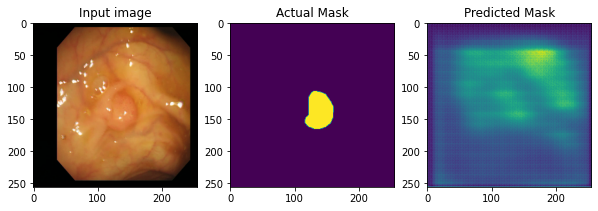

In [51]:
# print sample image after training
print_images()

## Unet Model

In [52]:
# 위에서 구성한 두가지 모델 중에서 하나를 선택해 주세요. 
# 여기서 선택을 바꾸어 다른 모델의 학습도 진행해 볼 수 있습니다. 

#print('select the Encoder-Decoder model')
#model = ed_model
#checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

print('select the U-Net model')
checkpoint_dir_unet =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the U-Net model


Compile

In [54]:
model_unet.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions_unet = model_unet(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions_unet.shape)

(8, 256, 256, 1)


In [55]:
model_unet.summary()

Model: "u_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block_4 (EncoderBloc multiple                  76416     
_________________________________________________________________
encoder_block_5 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_6 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_7 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_9 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block_4 (DecoderBloc multiple                  18882048  
_________________________________________________________________
decoder_block_5 (DecoderBloc multiple                  3542

### Callbacks
Callback 함수들을 이용하여, 학습 중간에 원하는 동작을 할 수 있도록 합니다.
ModelCheckpoint callback 함수는 모델 학습간 특정 feature를 모니터링하다 기준점을 넘으면 모델 파라미터를 저장하는 역할을 합니다.
LearningRateScheduler callback 함수는 학습을 진행하며, 주어진 인자의 값을 이용해 Learning rate를 조절해주는 함수입니다.
cos_decay는 cos 함수의 모양으로 Learning rate를 조절해 주는 learning rate decay 구현입니다.


In [56]:
if not os.path.isdir(checkpoint_dir_unet):
    os.makedirs(checkpoint_dir_unet)

cp_callback_unet = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir_unet,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)


In [57]:
cos_decay_unet = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback_unet = tf.keras.callbacks.LearningRateScheduler(cos_decay_unet, verbose=1)

Train your model
모델 학습 이전에, 모델에서 예측한 이미지를 출력할 수 있는 함수를 미리 작성해 모델 성능 테스트에 사용합니다.

In [58]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model_unet(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

Training - model.fit() 함수 이용
학습을 진행하며, 위에서 구성한 Train dataset과 Test dataset등을 이용해 학습을 진행합니다.
학습 데이터의 갯수가 부족하기때문에 Test dataset을 Validation dataset으로 사용할 것입니다.
아래는 model를 학습하는 코드입니다. 10 Epoch만 학습을 진행한 후, 미리 학습된 모델을 불러올 예정입니다.

In [59]:
history_unet = model_unet.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback_unet, lr_callback_unet]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 40s 973ms/step - loss: 0.9925 - dice_loss: 0.7318 - val_loss: 60945.9375 - val_dice_loss: 1.0000
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 28s 909ms/step - loss: 0.8975 - dice_loss: 0.6943 - val_loss: 18.6416 - val_dice_loss: 1.0000
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 29s 936ms/step - loss: 0.8245 - dice_loss: 0.6353 - val_loss: 18.7005 - val_dice_loss: 0.9998
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 29s 917ms/step - loss: 0.7967 - dice_loss: 0.6160 - val_loss: 13.205

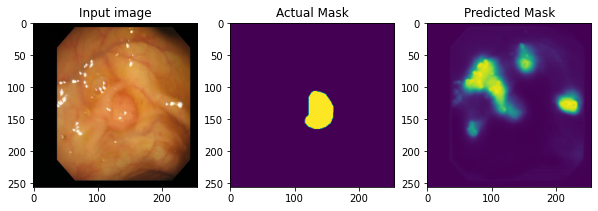

In [60]:
# print sample image after training
print_images()

Plot the loss
저장된 학습 진행과정(history)을 시각화해 봅시다.

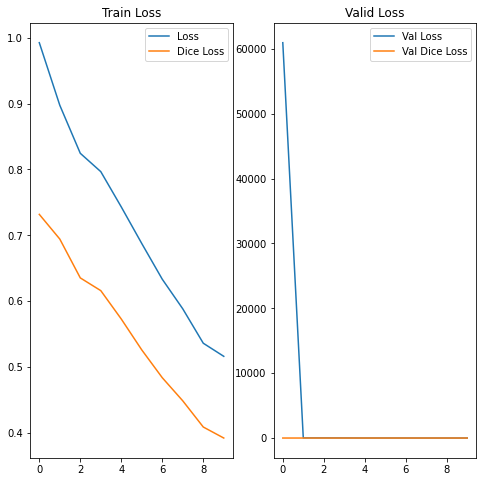

In [63]:
dice_loss = history_unet.history['dice_loss']
loss = history_unet.history['loss']
val_dice_loss = history_unet.history['val_dice_loss']
val_loss = history_unet.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

저장된 모델의 가중치를 불러옵니다. ed_ckpt나 unet_ckpt에 담긴 것이 미리 학습시킨 모델입니다. 직접 학습시킨 모델은 train_ckpt에 있습니다. 원하는 모델을 불러와 사용하세요.

In [65]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
# checkpoint_dir = os.path.join(DATASET_PATH, 'ed_ckpt/ed_model')
checkpoint_dir_unet = os.path.join(DATASET_PATH, 'unet_ckpt/unet_model')

# restoring the latest checkpoint in checkpoint_dir
model_unet.load_weights(checkpoint_dir_unet)

불러온 가중치를 이용해서 모델을 평가해 봅시다. meanIoU를 metric으로 하여 정량적으로 평가해 볼 수 있고, 실제 생성된 segmentation 이미지를 분석해서 정성적으로 평가해 볼 수 있습니다.

In [66]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

테스트 데이터셋을 불러와서 meanIoU 값을 구해 봅시다. 이 값이 우리가 훈련시킨 모델에 대한 정량적 성능 metric이 됩니다.

In [69]:
mean_unet = []

for images, labels in test_dataset:
    predictions_unet = model_unet(images, training=False)
    m = mean_iou(labels, predictions_unet)
    mean_unet.append(m)

mean_unet = np.array(mean_unet)
mean_unet = np.mean(mean_unet)
print("mean_iou: {}".format(mean_unet))

mean_iou: 0.9454407214103913


Test Dataset 내에 데이터들을 얼만큼 잘 맞추었는지 직접 확인해 봅시다.

In [70]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions_unet = model_unet(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions_unet[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

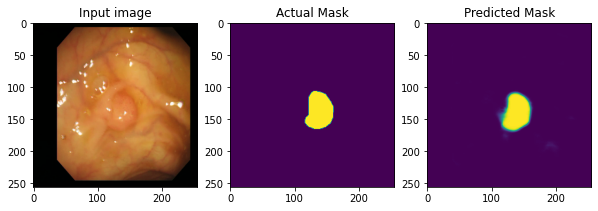

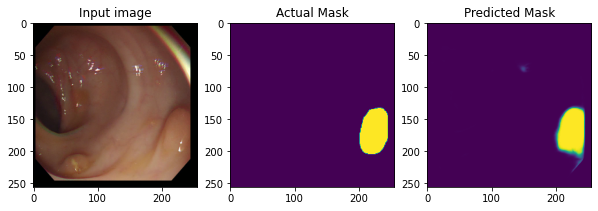

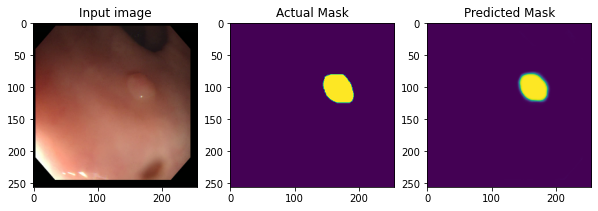

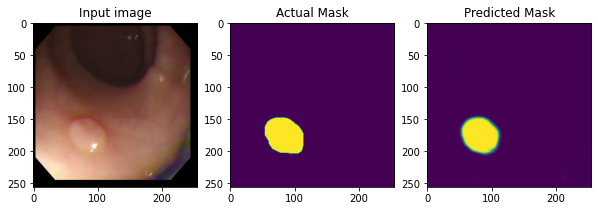

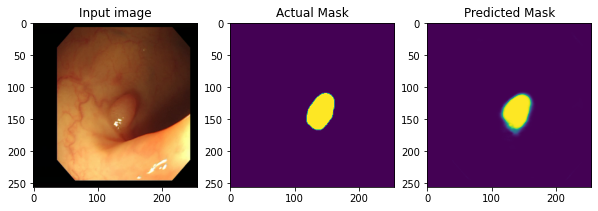

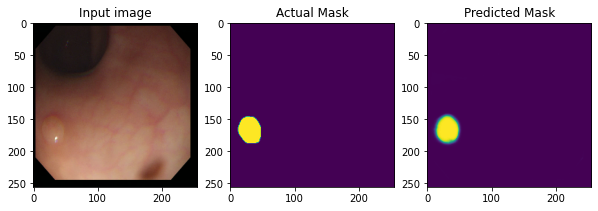

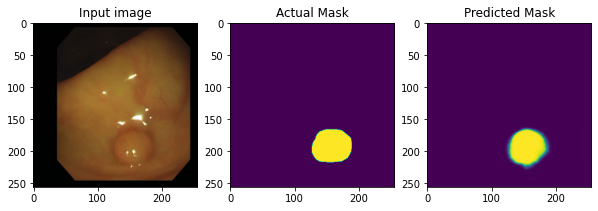

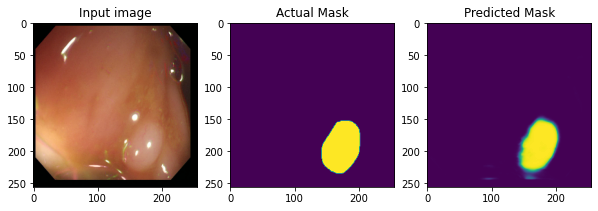

In [71]:
print_images()

# 프로젝트: U-Net 성능 개선해 보기

VGG16을 활용하기 위한
우선 VGG16 모델의 레이어 구성을 확인해 봅시다. U-Net이란 Encoder와 Decoder 사이의 대응되는 레이어간의 skip connection이 특징인 모델

In [72]:
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

58900480/58889256 [==============================] - 0s 0us/step


[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 32, 32, 256) dtype=float32 (created by layer 'block3_pool')>,


VGG16을 Encoder로 활용하여 개선한 새로운 모델 클래스입니다. 이 모델을 구성하기 위해서 내부에서 새로운 모델(vgg16_act)을 만들었는데, 이것은 VGG16의 특정 레이어 출력을 가져와 Decoder와 연결하기 위한 것입니다. 기존 UNet 클래스와 비교하면, encoder 레이어가 없어지고 vgg16_act 모델의 출력이 그 역할을 대신하고 있음을 알수 있습니다.

In [73]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

### STEP 3: 학습과 테스트, 시각화

In [96]:
vgg16 = Vgg16UNet()

In [97]:
print('select the VGG16 model')
model_vgg = vgg16
checkpoint_dir_vgg =os.path.join(DATASET_PATH,'train_ckpt/vgg_model')

select the VGG16 model


In [98]:
model_vgg.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions_vgg = model_vgg(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions_vgg.shape)

(8, 256, 256, 1)


In [99]:
model_vgg.summary()

Model: "vgg16u_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
model_1 (Functional)         [(None, 256, 256, 64), (N 14714688  
_________________________________________________________________
conv_block_11 (ConvBlock)    multiple                  0 (unused)
_________________________________________________________________
decoder_block_12 (DecoderBlo multiple                  9444864   
_________________________________________________________________
decoder_block_13 (DecoderBlo multiple                  2952960   
_________________________________________________________________
decoder_block_14 (DecoderBlo multiple                  739200    
_________________________________________________________________
decoder_block_15 (DecoderBlo multiple                 

In [100]:
if not os.path.isdir(checkpoint_dir_vgg):
    os.makedirs(checkpoint_dir_vgg)

cp_callback_vgg = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir_vgg,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [101]:
cos_decay_vgg = tf.keras.experimental.CosineDecay(1e-3,
                                              max_epochs)
lr_callback_vgg = tf.keras.callbacks.LearningRateScheduler(cos_decay_vgg, verbose=1)

In [102]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions_vgg = model_vgg(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [103]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    bce = losses.binary_crossentropy(y_true, y_pred)
    bce = tf.reduce_mean(bce)
    dice = dice_loss(y_true, y_pred)
    loss =  bce + dice
    return loss


In [104]:

history_vgg = model_vgg.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback_vgg, lr_callback_vgg]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 26s 598ms/step - loss: 0.9860 - dice_loss: 0.7347 - val_loss: 2.1795 - val_dice_loss: 1.0000
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 19s 603ms/step - loss: 0.9094 - dice_loss: 0.7046 - val_loss: 1.5185 - val_dice_loss: 0.8043
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 20s 622ms/step - loss: 0.8945 - dice_loss: 0.6911 - val_loss: 1.9642 - val_dice_loss: 0.8320
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 20s 617ms/step - loss: 0.8873 - dice_loss: 0.6875 - val_loss: 1.0401 - val

### STEP 4: 모델 성능 비교분석

모델 성능 테스트에 사용

In [105]:
## Define print function
def print_images(model):
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

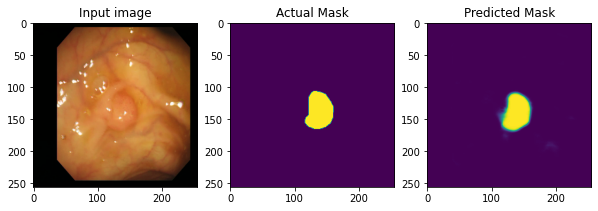

In [106]:
# Unet print sample image after training
print_images(model_unet)

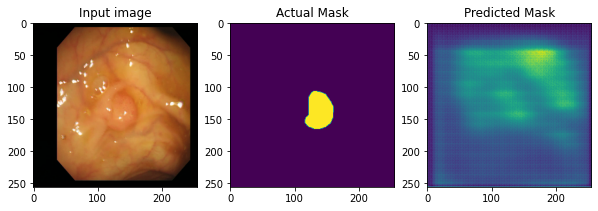

In [107]:
# ED(Encoder-Decoer) print sample image after training
print_images(model_ed)

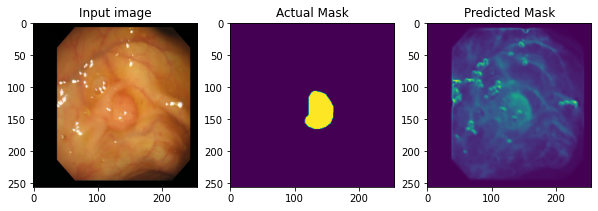

In [108]:
# print sample image after training
print_images(model_vgg)

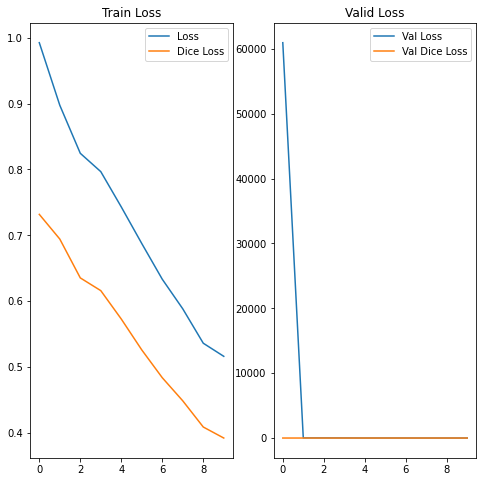

In [109]:
# Unet Model

dice_loss = history_unet.history['dice_loss']
loss = history_unet.history['loss']
val_dice_loss = history_unet.history['val_dice_loss']
val_loss = history_unet.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

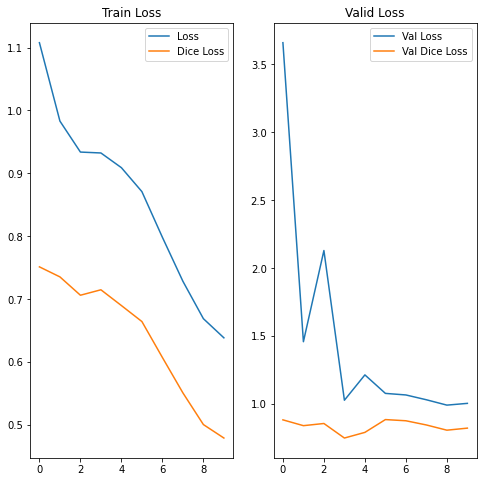

In [110]:
# ED(Encoder-Decoder) Model

dice_loss = history_ed.history['dice_loss']
loss = history_ed.history['loss']
val_dice_loss = history_ed.history['val_dice_loss']
val_loss = history_ed.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

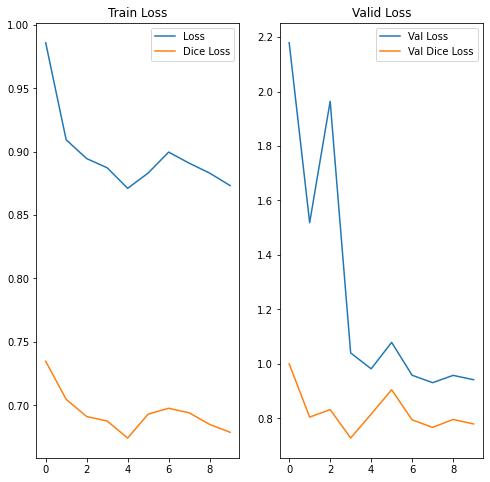

In [111]:
# VGG Model

dice_loss = history_vgg.history['dice_loss']
loss = history_vgg.history['loss']
val_dice_loss = history_vgg.history['val_dice_loss']
val_loss = history_vgg.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

#### 테스트 데이터셋을 불러와서 meanIoU 값을 구해 봅시다. 

In [121]:
# 위에서 구성한 두가지 모델 중에서 하나를 선택해 주세요. 
# 여기서 선택을 바꾸어 다른 모델의 학습도 진행해 볼 수 있습니다. 

print('select the Encoder-Decoder model')
checkpoint_dir_ed =os.path.join(DATASET_PATH,'train_ckpt/ed_model')
# restoring the latest checkpoint in checkpoint_dir
model_ed.load_weights(checkpoint_dir_ed)


print('select the U-Net model')
checkpoint_dir_unet =os.path.join(DATASET_PATH,'train_ckpt/unet_model')
# restoring the latest checkpoint in checkpoint_dir
model_unet.load_weights(checkpoint_dir_unet)


print('select the VGG model')
checkpoint_dir_vgg =os.path.join(DATASET_PATH,'train_ckpt/vgg_model')
# restoring the latest checkpoint in checkpoint_dir
model_vgg.load_weights(checkpoint_dir_vgg)

select the Encoder-Decoder model
select the U-Net model
select the VGG model


In [118]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [130]:
def get_mean(model):
    mean = []
    for images, labels in test_dataset:
        predictions = model(images, training=False)
        m = mean_iou(labels, predictions)
        mean.append(m)

    mean = np.array(mean)
    mean = np.mean(mean)
    return mean

In [131]:

mean_unet = get_mean(model_unet)
print("mean unet iou: {}".format(mean_unet))

mean_ed = get_mean(model_ed)
print("mean ed(Encoder-Decoder) iou: {}".format(mean_ed))

mean_vgg = get_mean(model_vgg)
print("mean VGG iou: {}".format(mean_vgg))




mean unet iou: 0.5863310866955865
mean ed(Encoder-Decoder) iou: 0.4761827301207513
mean VGG iou: 0.4755070571349641


#### Test Dataset 내에 데이터들을 얼만큼 잘 맞추었는지 직접 확인해 봅시다.

In [135]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions_unet = model_unet(test_images, training=False)
        predictions_ed = model_ed(test_images, training=False)
        predictions_vgg = model_vgg(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 5, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 5, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 5, 3)
            plt.imshow(predictions_unet[i, :, :, 0])
            plt.title("Predicted Unet")
            plt.show()
            
            plt.subplot(1, 5, 4)
            plt.imshow(predictions_ed[i, :, :, 0])
            plt.title("Predicted Ed")
            plt.show()
            
            plt.subplot(1, 5, 5)
            plt.imshow(predictions_vgg[i, :, :, 0])
            plt.title("Predicted VGG")
            plt.show()

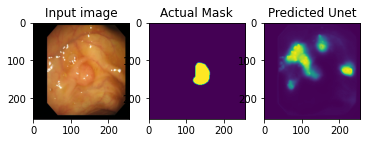

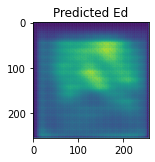

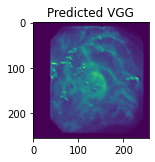

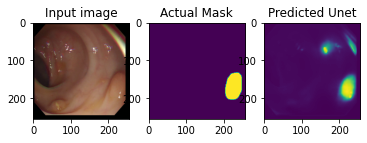

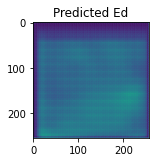

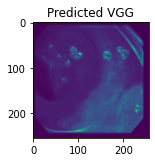

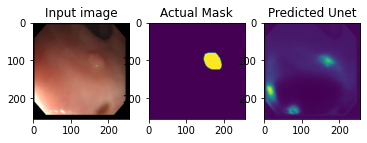

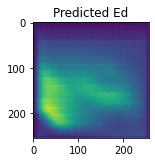

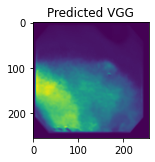

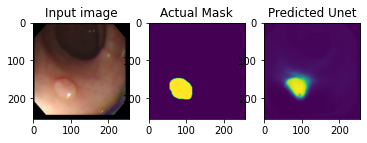

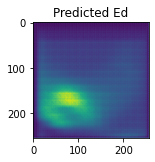

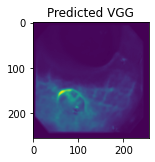

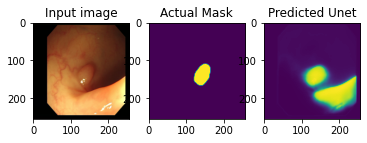

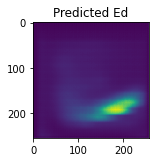

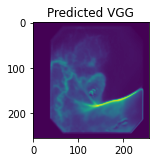

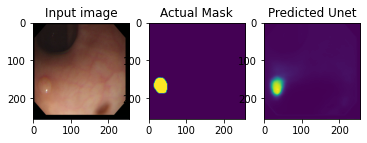

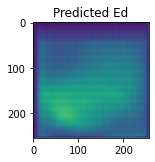

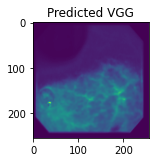

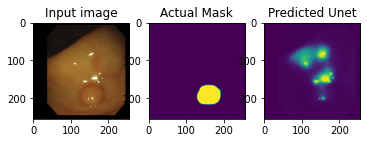

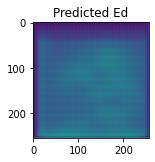

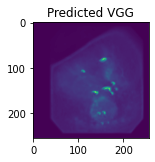

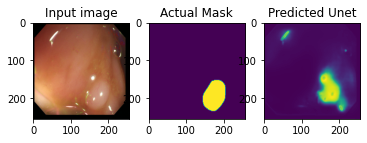

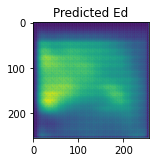

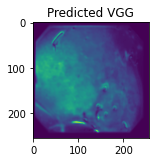

In [138]:
print_images()

끝: 생각대로 ... unet 보다 잘 나오지 않지만 그래도 샘플 코드도 있고 빈칸 맞추기라 다행이 작업은 진행할 수 있어서 다행이네요.